# 1. Setup
Setup MIRT and "reproduce-l-s-dynamic-mri" matlab projects

 - https://github.com/JeffFessler/mirt
 - https://github.com/JeffFessler/reproduce-l-s-dynamic-mri
   - And it is based on Ricardo Otazo's code: http://cai2r.net/resources/software/ls-reconstruction-matlab-code

*Note: in order to make this notebook work, I installed Matlab's python engine (https://www.mathworks.com/help/matlab/matlab_external/install-matlab-engine-api-for-python-in-nondefault-locations.html), and also a Matlab kernel for Jupyter (https://github.com/Calysto/matlab_kernel)*

In [1]:
addpath('../mirt')
run('../mirt/setup')
addpath('../reproduce-l-s-dynamic-mri/data')
addpath('../reproduce-l-s-dynamic-mri/toolbox_pincat/')
addpath('../reproduce-l-s-dynamic-mri/operators/')
addpath('../reproduce-l-s-dynamic-mri/algorithms/')

The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/hakkelt/mri/mirt".
> In path (line 109)
  In addpath (line 86)
  In setup (line 70)
  In run (line 91)
Path setup for irt appears to have succeeded.


# 2. PINCAT phantom example
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_PINCAT_phantom.m

## 2.1 Preparation

**Read data**

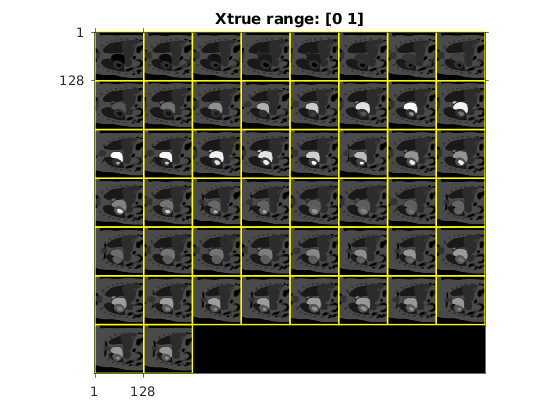

In [2]:
% L+S reconstruction of undersampled multicoil PINCAT phantom
% Claire Lin, 06/05/2018
clear all;close all;
load('data/aperiodic_pincat.mat')
load('data/Xinf.mat')
tmp = max(new(:));
Xtrue = div0(new,tmp);
[nx,ny,nt] = size(Xtrue);
im(Xtrue)

**Simulate coil maps**

Code for `ir_mri_sensemap_sim`: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/toolbox_pincat/ir_mri_sensemap_sim.m

warn im: magnitude of complex image


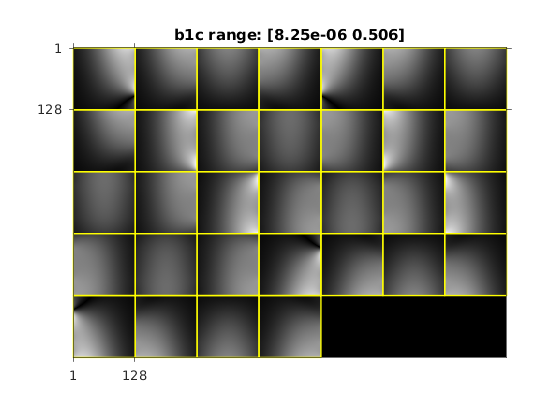

In [3]:
%% simulate coil maps
% 4 rings of 8 coils
nc = 8;
nring = 4;
b1 = ir_mri_sensemap_sim('chat', 0, 'nx', nx, 'ny', 1, 'nz', ny,'dx', 1.5, 'dz', 1.5, ...
	'rcoil', 120, 'nring', nring, 'ncoil', nc*nring, 'coil_distance', 1.2);
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);
im(b1c)

**Coil compression to 8 coils**

MRI coil compression via PCA<br>
Given multiple MRI surface coil images (b1c), use SVD/PCA to find a smaller number of virtual coil images.

warn im: magnitude of complex image


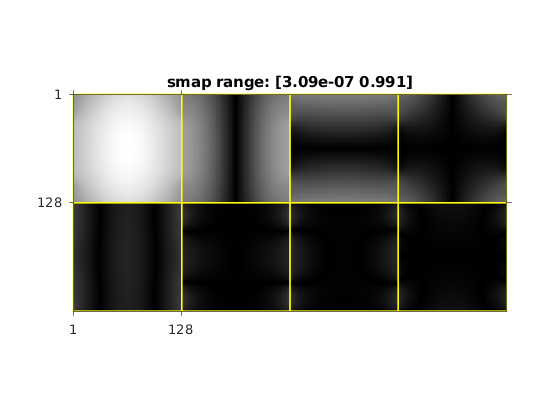

In [4]:
%% coil compression to 8 coils
[smap0, ~] = ir_mri_coil_compress(b1c, 'ncoil', nc);
tmp = sqrt(sum(abs((smap0)).^2,3));
smap = div0(smap0,tmp);
im(smap)

**Sampling mask**

Code for `strucrand` can be found here: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/toolbox_pincat/strucrand.m

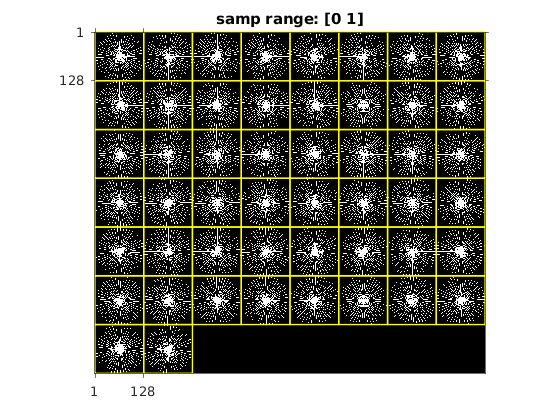

In [5]:
%% sampling mask
line = 24;
samp = strucrand(nx,ny,nt,line);
im(samp)

**Acquisition operator and measured data**

Code for `getE`: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/operators/getE.m

In [6]:
%% data
E=getE(smap,nt,'samp',samp);
d = E*Xtrue;

**Add noise and prepare for regularization scaling**

Add complex noise such that the $SNR = 46dB$

: data rmse = 0.000425417, snr = 46


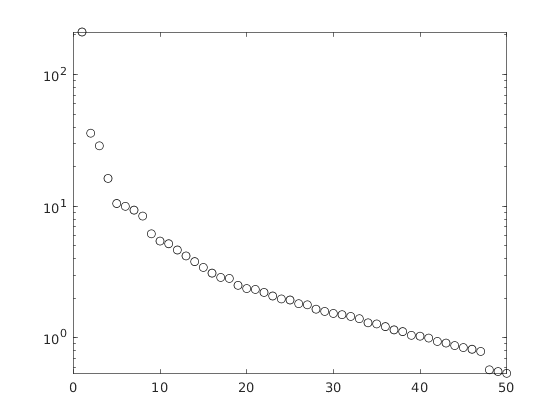

In [7]:
% add noise
rng(0)
dn = randn(size(d)) + 1i * randn(size(d));
param.snr_db = 46;
param.scale_noise = norm(d(:)) / norm(dn(:)) / 10.^(param.snr_db / 20);
param.d = d + param.scale_noise * dn;
printm('data rmse = %g, snr = %g', rms(param.d(:)-d(:)), ...
    20*log10(norm(d(:)) / norm(param.d(:)-d(:))))
opt.d = param.d;

% prepare for regularization scaling
L = E'*param.d; 
res = E*L-param.d;
[~,St,~]=svd(reshape(L,[nx*ny,nt])-reshape(E'*res,[nx*ny,nt]),0);
semilogy(diag(St),'ok')

## 2.2 Test algorithms

**Prepare for augmented Lagrangian algorithms**

In [8]:
%% prepare for AL: opt
opt.smap = smap;
opt.T=getT(nx,ny,nt);
opt.nite = 10;
opt.samp = samp;
[opt.F,opt.C] = getFS(opt.smap,nt,'samp',opt.samp);
opt.E=getE(smap,nt,'samp',opt.samp);
opt.scaleL = St(1);
opt.scaleS = 1/1.887; %1 / b1 constant squared in middle of image
opt.muL=0.01;
opt.muS=0.05*opt.scaleS;
opt.Xinf = Xinf.pincat;

**Run AL-CG**

In [9]:
%% AL-CG
d1 = 1/2; d2 = 1/2; %for AL-CG
c = clock();
[L_cg,S_cg,x_cg,cost_cg,time_cg,rankL_cg] = AL_CG(opt,'d1',d1,'d2',d2);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 25.3092403, cost: 951.1688233, rank of L: 50
 ********** AL-CG: L+S reconstruction **********
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 3.3e-05.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.00035.
 ite: 1 , rank of L: 49, xdiff: 13.7454393, cost: 863.6173103
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 1.8e-05.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.00032.
 ite: 2 , rank of L: 25, xdiff: 10.4156443, cost: 81

**Run AL-2**

In [10]:
%% AL-2
d1 = 1/3; d2 = 1/10; %for AL-2
c = clock();
[L_al,S_al,xdiff_al,cost_al,time_al,rankL_al] = AL_2(opt,'d1',d1,'d2',d2);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 25.3092403, cost: 951.1688233, rank of L: 50
 ********** AL-2: L+S reconstruction **********
 ite: 1 , rank of L: 3, xdiff: 41.9408913, cost: 1417.4295653
 ite: 2 , rank of L: 3, xdiff: 26.8228993, cost: 961.5783083
 ite: 3 , rank of L: 4, xdiff: 18.7992523, cost: 816.4223633
 ite: 4 , rank of L: 6, xdiff: 12.6015103, cost: 747.2053223
 ite: 5 , rank of L: 7, xdiff: 9.3126613, cost: 724.4708253
 ite: 6 , rank of L: 7, xdiff: 7.8415493, cost: 717.4979863
 ite: 7 , rank of L: 8, xdiff: 6.7806903, cost: 712.8419803
 ite: 8 , rank of L: 8, xdiff: 6.0018883, cost: 709.7363283
 ite: 9 , rank of L: 8, xdiff: 5.5401633, cost: 708.1655273
 ite: 10 , rank of L: 8, xdiff: 5.1972273, cost: 707.1064453

elapsed time: 17.8129


**Prepare for PGM algorithms**

In [11]:
%% prepare for PGM: param
param.E = getE(smap,nt,'samp',samp);
param.T = getT(nx,ny,nt);
param.nite = 10;
param.scaleL = St(1);
param.scaleS = 1/1.887; %1 / b1 constant squared in middle of image
param.lambda_L=0.01;
param.lambda_S=0.05*param.scaleS;
param.Xinf = reshape(Xinf.pincat,nx*ny,nt);

**Run ISTA**

In [12]:
%% ISTA
c = clock();
[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 25.3092403, cost: 951.1688233, rank of L: 50
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 20, xdiff: 15.8493393, cost: 786.3693853
 ite: 2, rank of L: 15, xdiff: 11.1977013, cost: 752.6289673
 ite: 3, rank of L: 13, xdiff: 9.0156423, cost: 738.7617193
 ite: 4, rank of L: 12, xdiff: 7.5550733, cost: 732.6481933
 ite: 5, rank of L: 12, xdiff: 6.9909103, cost: 729.1419683
 ite: 6, rank of L: 12, xdiff: 6.4011543, cost: 726.5877693
 ite: 7, rank of L: 11, xdiff: 6.2127023, cost: 724.5297243
 ite: 8, rank of L: 11, xdiff: 5.8614373, cost: 722.7829593
 ite: 9, rank of L: 11, xdiff: 5.7729363, cost: 721.2694093
 ite: 10, rank of L: 10, xdiff: 5.5149013, cost: 719.9468993

elapsed time: 1.7272


**Run FISTA**

In [13]:
%% FISTA
c = clock();
[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 25.3092403, cost: 951.1688233, rank of L: 50
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 34, xdiff: 19.3698183, cost: 831.9344483
 ite: 2, rank of L: 23, xdiff: 15.8861963, cost: 787.8776253
 ite: 3, rank of L: 18, xdiff: 12.7468273, cost: 761.8648073
 ite: 4, rank of L: 15, xdiff: 10.2047963, cost: 745.7527473
 ite: 5, rank of L: 13, xdiff: 8.3865943, cost: 736.0908813
 ite: 6, rank of L: 12, xdiff: 7.2166353, cost: 730.9735113
 ite: 7, rank of L: 12, xdiff: 6.5144553, cost: 727.4960943
 ite: 8, rank of L: 11, xdiff: 6.0735573, cost: 724.6638793
 ite: 9, rank of L: 11, xdiff: 5.7702753, cost: 722.1716313
 ite: 10, rank of L: 10, xdiff: 5.5237363, cost: 719.9782713

elapsed time: 2.4069


**Run POGM**

In [14]:
%% POGM
c = clock();
[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 25.3092403, cost: 951.1688233, rank of L: 50
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 25, xdiff: 16.8706053, cost: 796.9192503
 ite: 2, rank of L: 15, xdiff: 11.4006803, cost: 753.0890503
 ite: 3, rank of L: 12, xdiff: 8.1827443, cost: 735.4837653
 ite: 4, rank of L: 12, xdiff: 6.6846283, cost: 728.9039923
 ite: 5, rank of L: 11, xdiff: 6.0296173, cost: 724.5433353
 ite: 6, rank of L: 10, xdiff: 5.6109743, cost: 720.9524543
 ite: 7, rank of L: 9, xdiff: 5.3057743, cost: 717.9908453
 ite: 8, rank of L: 9, xdiff: 5.0435533, cost: 715.4371953
 ite: 9, rank of L: 9, xdiff: 4.8189883, cost: 713.3032843
 ite: 10, rank of L: 9, xdiff: 4.6525973, cost: 711.9748543

elapsed time: 1.7870


# 3. Multicoil cardiac cine MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_cine.m

## 3.1 Preparation

**Read data**

In [15]:
% L+S reconstruction of undersampled multicoil cardiac cine MRI
% Claire Lin, 05/20/2018
clear all;close all;
load('data/cardiac_cine_R6.mat')
load ('data/Xinf.mat')
%% normalize smap
[nx,ny,nt,nc]=size(kdata);
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);

## 3.2 Test algorithms

**Prepare for augmented Lagrangian methods**

In [16]:
%% prepare for AL: opt
opt.d = kdata;
opt.smap = b1c;
opt.T=getT(nx,ny,nt);
opt.nite = 10;
opt.samp = opt.d(:,:,:,1)~=0;
[opt.F,opt.C] = getFS(opt.smap,nt,'samp',opt.samp);
opt.E=getE(b1c,nt,'samp',opt.samp);
% scalers to match Otazo's results
opt.scaleL = 175/1.2656; % Otazo's stopping St(1) / b1 constant squared
opt.scaleS = 1/1.2656; % 1 / b1 constant squared
opt.muL=0.01;
opt.muS=0.0025*opt.scaleS;
opt.Xinf = Xinf.cine;

**Run AL-CG**

In [17]:
%% AL-CG
d1 = 1/10; d2 = 1/20; %for AL-CG
c = clock();
[L_cg,S_alcg,x_alcg,cost_alcg,time_alcg,rankL_alcg] = AL_CG(opt,'d1',d1,'d2',d2);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** AL-CG: L+S reconstruction **********
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0034.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.036.
 ite: 1 , rank of L: 24, xdiff: 51.1746563, cost: 682.8310873
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0026.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.016.
 ite: 2 , rank of L: 24, xdiff: 28.9228803, cost: 574.85

**Run AL-2**

In [18]:
%% AL-2
d1 = 1/10; d2 = 1/100;  %for AL-2
c = clock();
[L_al2,S_al2,xdiff_al2,cost_al2,time_al2,rankL_al2] = AL_2(opt,'d1',d1,'d2',d2);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** AL-2: L+S reconstruction **********
 ite: 1 , rank of L: 1, xdiff: 95.6885453, cost: 2365.8748573
 ite: 2 , rank of L: 1, xdiff: 65.7433623, cost: 798.3235803
 ite: 3 , rank of L: 0, xdiff: 53.3320393, cost: 413.0994443
 ite: 4 , rank of L: 0, xdiff: 46.7413293, cost: 323.3674703
 ite: 5 , rank of L: 0, xdiff: 41.2476313, cost: 289.0024733
 ite: 6 , rank of L: 0, xdiff: 36.6471563, cost: 269.1716313
 ite: 7 , rank of L: 0, xdiff: 33.0463753, cost: 258.1183483
 ite: 8 , rank of L: 0, xdiff: 30.2602373, cost: 251.8830083
 ite: 9 , rank of L: 0, xdiff: 28.1066283, cost: 248.0244133
 ite: 10 , rank of L: 0, xdiff: 26.4248773, cost: 245.1701213

elapsed time: 55.2986


**Prepare for PGM algorithms**

In [19]:
%% prepare for PGM: param
param.E=getE(b1c,nt,'samp',kdata(:,:,:,1)~=0);
param.d=kdata;
param.T = getT(nx,ny,nt);
param.nite=10;
param.scaleL = 175/1.2656;
param.scaleS = 1/1.2656;
param.lambda_L=0.01;
param.lambda_S=0.0025*param.scaleS;
param.Xinf = reshape(Xinf.cine,nx*ny,nt);

**Run ISTA**

In [20]:
%% ISTA
c = clock();
[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 24, xdiff: 77.2504503, cost: 931.0880953
 ite: 2, rank of L: 24, xdiff: 67.1571043, cost: 782.0542613
 ite: 3, rank of L: 24, xdiff: 60.1077463, cost: 709.3672743
 ite: 4, rank of L: 24, xdiff: 54.7802243, cost: 658.1694593
 ite: 5, rank of L: 23, xdiff: 50.2011303, cost: 617.5562673
 ite: 6, rank of L: 21, xdiff: 46.3694113, cost: 584.0904523
 ite: 7, rank of L: 19, xdiff: 42.9700513, cost: 556.4205143
 ite: 8, rank of L: 16, xdiff: 40.0760083, cost: 533.0474603
 ite: 9, rank of L: 15, xdiff: 37.5284423, cost: 513.8099193
 ite: 10, rank of L: 13, xdiff: 35.3816603, cost: 498.0421783

elapsed time: 5.5376


**Run FISTA**

In [21]:
%% FISTA
c = clock();
[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 24, xdiff: 89.7275773, cost: 1203.0921193
 ite: 2, rank of L: 24, xdiff: 79.3396383, cost: 952.7407733
 ite: 3, rank of L: 24, xdiff: 71.1560133, cost: 821.6829323
 ite: 4, rank of L: 24, xdiff: 64.3450703, cost: 743.5552883
 ite: 5, rank of L: 24, xdiff: 58.3090363, cost: 686.0264113
 ite: 6, rank of L: 24, xdiff: 52.7729343, cost: 637.1883603
 ite: 7, rank of L: 23, xdiff: 47.6568833, cost: 593.8171413
 ite: 8, rank of L: 20, xdiff: 42.9705733, cost: 555.9679033
 ite: 9, rank of L: 16, xdiff: 38.7736433, cost: 523.7240033
 ite: 10, rank of L: 13, xdiff: 35.1568373, cost: 497.8138393

elapsed time: 7.5572


**Run POGM**

In [22]:
%% POGM
c = clock();
[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 24, xdiff: 80.6012043, cost: 968.3333903
 ite: 2, rank of L: 24, xdiff: 67.3216093, cost: 779.9223193
 ite: 3, rank of L: 24, xdiff: 57.6739773, cost: 686.7232793
 ite: 4, rank of L: 23, xdiff: 49.5012823, cost: 613.9794813
 ite: 5, rank of L: 19, xdiff: 42.4597663, cost: 555.2589473
 ite: 6, rank of L: 14, xdiff: 36.5725523, cost: 509.8669403
 ite: 7, rank of L: 8, xdiff: 32.0292363, cost: 479.2692883
 ite: 8, rank of L: 5, xdiff: 28.7907943, cost: 461.0693393
 ite: 9, rank of L: 3, xdiff: 26.4333953, cost: 449.8849533
 ite: 10, rank of L: 3, xdiff: 24.9634973, cost: 442.2500543

elapsed time: 5.7645


# 4. Multicoil cardiac perfusion MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_perf.m

## 4.1 Preparation

**Read data**

In [23]:
% L+S reconstruction of undersampled multicoil cardiac perfusion MRI
% Claire Lin, 05/20/2018
clear all;close all;
load('data/cardiac_perf_R8.mat')
load('data/Xinf.mat')
%% normalize smap
[nx,ny,nt,nc]=size(kdata);
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);

## 4.2 Test algorithms

**Prepare for Augmented Lagrangian algorithms**

In [24]:
%% prepare for AL: opt
opt.d = kdata;
opt.smap = b1c;
opt.T=getT(nx,ny,nt);
opt.nite = 10;
opt.samp = opt.d(:,:,:,1)~=0;
[opt.F,opt.C] = getFS(opt.smap,nt,'samp',opt.samp);
opt.E=getE(b1c,nt,'samp',opt.samp);
% scalers to match Otazo's results
opt.scaleL = 130/1.2775; % Otazo's stopping St(1) / b1 constant squared
opt.scaleS = 1/1.2775; % 1 / b1 constant squared
opt.muL=0.01;
opt.muS=0.01*opt.scaleS;
opt.Xinf = Xinf.perf;

**Run AL-CG**

In [25]:
%% AL-CG
d1 = 1/5; d2 = 1/5; %for AL-CG
c = clock();
[L_cg,S_cg,x_cg,cost_cg,time_cg,rankL_cg] = AL_CG(opt,'d1',d1,'d2',d2);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** AL-CG: L+S reconstruction **********
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0018.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0068.
 ite: 1 , rank of L: 40, xdiff: 81.4396513, cost: 677.7361773
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.00054.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0045.
 ite: 2 , rank of L: 40, xdiff: 63.3424423, cost: 580

**Run AL-2**

In [26]:
%% AL-2
d1 = 1/5; d2 = 1/50; %for AL-2
c = clock();
[L_al,S_al,xdiff_al,cost_al,time_al,rankL_al] = AL_2(opt,'d1',d1,'d2',d2);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** AL-2: L+S reconstruction **********
 ite: 1 , rank of L: 1, xdiff: 118.0958713, cost: 2919.1098513
 ite: 2 , rank of L: 1, xdiff: 89.0041583, cost: 1310.4811123
 ite: 3 , rank of L: 3, xdiff: 77.6117863, cost: 820.5040173
 ite: 4 , rank of L: 3, xdiff: 70.6298073, cost: 642.2338453
 ite: 5 , rank of L: 4, xdiff: 64.0606163, cost: 552.3495333
 ite: 6 , rank of L: 5, xdiff: 58.0906793, cost: 500.7592743
 ite: 7 , rank of L: 5, xdiff: 52.7845843, cost: 469.7612703
 ite: 8 , rank of L: 4, xdiff: 48.1143843, cost: 450.6305853
 ite: 9 , rank of L: 4, xdiff: 44.0771873, cost: 438.6039523
 ite: 10 , rank of L: 4, xdiff: 40.6270413, cost: 430.6803203

elapsed time: 27.5002


**Prepare for PGM algorithms**

In [27]:
%% prepare for PGM: param
param.E=getE(b1c,nt,'samp',kdata(:,:,:,1)~=0);
param.d=kdata;
param.T = getT(nx,ny,nt);
param.nite=10;
param.scaleL = 130/1.2775;
param.scaleS = 1/1.2775;
param.lambda_L=0.01;
param.lambda_S=0.01*param.scaleS;
param.Xinf = reshape(Xinf.perf,nx*ny,nt);

**Run ISTA**

In [28]:
%% ISTA
c = clock();
[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 94.7225423, cost: 819.4575223
 ite: 2, rank of L: 40, xdiff: 86.7924423, cost: 707.9456013
 ite: 3, rank of L: 40, xdiff: 80.7610023, cost: 651.7363823
 ite: 4, rank of L: 40, xdiff: 75.9018943, cost: 612.8571323
 ite: 5, rank of L: 38, xdiff: 71.5280463, cost: 583.2456303
 ite: 6, rank of L: 36, xdiff: 67.6884923, cost: 559.7511453
 ite: 7, rank of L: 33, xdiff: 64.1339653, cost: 540.6652673
 ite: 8, rank of L: 29, xdiff: 60.9227943, cost: 524.8275273
 ite: 9, rank of L: 28, xdiff: 57.9282653, cost: 511.4539013
 ite: 10, rank of L: 27, xdiff: 55.1851813, cost: 499.9599543

elapsed time: 2.2775


**Run FISTA**

In [29]:
%% FISTA
c = clock();
[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 103.8934403, cost: 1016.8542883
 ite: 2, rank of L: 40, xdiff: 96.2738493, cost: 836.7154403
 ite: 3, rank of L: 40, xdiff: 89.9116443, cost: 738.6073813
 ite: 4, rank of L: 40, xdiff: 84.2732853, cost: 678.2913103
 ite: 5, rank of L: 40, xdiff: 78.9840853, cost: 633.9038893
 ite: 6, rank of L: 40, xdiff: 73.8725053, cost: 597.3557363
 ite: 7, rank of L: 37, xdiff: 68.8839953, cost: 566.2765563
 ite: 8, rank of L: 33, xdiff: 64.0132223, cost: 539.8553613
 ite: 9, rank of L: 29, xdiff: 59.2761233, cost: 517.4710143
 ite: 10, rank of L: 27, xdiff: 54.7063873, cost: 498.4585513

elapsed time: 3.1283


**Run POGM**

In [30]:
%% POGM
c = clock();
[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 97.3583763, cost: 849.4886573
 ite: 2, rank of L: 40, xdiff: 86.9139863, cost: 707.7278993
 ite: 3, rank of L: 40, xdiff: 78.6276933, cost: 635.4357403
 ite: 4, rank of L: 37, xdiff: 71.0008163, cost: 580.9478443
 ite: 5, rank of L: 32, xdiff: 63.7240603, cost: 539.0874053
 ite: 6, rank of L: 28, xdiff: 56.7864073, cost: 506.9395343
 ite: 7, rank of L: 22, xdiff: 50.2903563, cost: 481.9811793
 ite: 8, rank of L: 19, xdiff: 44.3746223, cost: 462.8262993
 ite: 9, rank of L: 16, xdiff: 39.1518293, cost: 448.2832673
 ite: 10, rank of L: 13, xdiff: 35.6455923, cost: 439.4732693

elapsed time: 2.3336


# 5. Multicoil abdominal dce MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_abdomen_dce_ga.m

## 5.1 Preparation

**Read data**

In [31]:
% L+S reconstruction of undersampled multicoil abdominal dce MRI
% Claire Lin, 05/07/2019
%clear all;close all;
load('data/abdomen_dce_ga.mat')
load ('data/Xinf.mat')
%% number of spokes to be used per frame (Fibonacci number)
nspokes=21;
[nx,ny,nc]=size(b1);
[nr,ntviews,nc]=size(kdata);
% number of frames
nt=floor(ntviews/nspokes);
% crop the data according to the number of spokes per frame
kdata=kdata(:,1:nt*nspokes,:);
k=k(:,1:nt*nspokes);
w=w(:,1:nt*nspokes);
% sort the data into a time-series of undersampled images
for ii=1:nt
    kdatau(:,:,:,ii)=kdata(:,(ii-1)*nspokes+1:ii*nspokes,:);
    ku(:,:,ii)=k(:,(ii-1)*nspokes+1:ii*nspokes);
    wu(:,:,ii)=w(:,(ii-1)*nspokes+1:ii*nspokes);
end
%% normalize smap
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);
%% prepare for system operator
ksp = reshape(ku,[],nt); 
ksp3(:,1,:) = real(ksp);
ksp3(:,2,:) = imag(ksp);
om3 = ksp3*2*pi;
wi3 = reshape(wu,[],nt);
M = size(ksp,1);

## 5.2 Test algorithms

**Prepare for PGM algorithms**

In [32]:
%% prepare for PGM: param
param.E = getEnufft(b1c,nt,'M',M,'ksp',ksp3,'om',om3,'wi',wi3,'donufft',1);
param.d=permute(reshape(kdatau,[],nc,nt),[1 3 2]);
recon_nufft=param.E'*param.d;
tscale = 1.3002; %power iteration on E'E
param.scaleL = 0.0274/1.099;
param.scaleS = 1/1.099;
param.lambda_L=0.025;
param.lambda_S=0.5*max(abs(recon_nufft(:)))*param.scaleS;
param.nite=10;
param.tol=0.0025;
param.T= getT(nx,ny,nt);
param.Xinf = reshape(Xinf.abd,nx*ny,nt);

**Run ISTA**

In [33]:
%% ISTA
c = clock();
[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param,'tscale',tscale);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 0.1836113, cost: 0.1563813, rank of L: 28
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 28, xdiff: 0.1589423, cost: 0.1228233
 ite: 2, rank of L: 28, xdiff: 0.1390143, cost: 0.0988193
 ite: 3, rank of L: 28, xdiff: 0.1228113, cost: 0.0814433
 ite: 4, rank of L: 28, xdiff: 0.1095723, cost: 0.0687143
 ite: 5, rank of L: 28, xdiff: 0.0987063, cost: 0.0592753
 ite: 6, rank of L: 28, xdiff: 0.0897413, cost: 0.0521893
 ite: 7, rank of L: 28, xdiff: 0.0823043, cost: 0.0468013
 ite: 8, rank of L: 28, xdiff: 0.0760943, cost: 0.0426523
 ite: 9, rank of L: 28, xdiff: 0.0708683, cost: 0.0394143
 ite: 10, rank of L: 28, xdiff: 0.0664323, cost: 0.0368533

elapsed time: 141.8108


**Run FISTA**

In [34]:
%% FISTA
c = clock();
[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1,'tscale',tscale);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 0.1836113, cost: 0.1563813, rank of L: 28
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 28, xdiff: 0.1711183, cost: 0.1388273
 ite: 2, rank of L: 28, xdiff: 0.1598423, cost: 0.1239173
 ite: 3, rank of L: 28, xdiff: 0.1467873, cost: 0.1077923
 ite: 4, rank of L: 28, xdiff: 0.1327333, cost: 0.0918233
 ite: 5, rank of L: 28, xdiff: 0.1183843, cost: 0.0770323
 ite: 6, rank of L: 28, xdiff: 0.1043563, cost: 0.0640723
 ite: 7, rank of L: 28, xdiff: 0.0911583, cost: 0.0532543
 ite: 8, rank of L: 28, xdiff: 0.0791733, cost: 0.0446053
 ite: 9, rank of L: 28, xdiff: 0.0686443, cost: 0.0379483
 ite: 10, rank of L: 28, xdiff: 0.0596753, cost: 0.0329913

elapsed time: 256.7163


**Run POGM**

In [35]:
%% POGM
c = clock();
[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1,'tscale',tscale);
fprintf('\nelapsed time: %.4f\n', etime(clock(), c))

 ite: 0, xdiff: 0.1836113, cost: 0.1563813, rank of L: 28
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 28, xdiff: 0.1634303, cost: 0.1285963
 ite: 2, rank of L: 28, xdiff: 0.1400943, cost: 0.1000613
 ite: 3, rank of L: 28, xdiff: 0.1161853, cost: 0.0749463
 ite: 4, rank of L: 28, xdiff: 0.0938363, cost: 0.0553433
 ite: 5, rank of L: 28, xdiff: 0.0746013, cost: 0.0415433
 ite: 6, rank of L: 28, xdiff: 0.0593243, cost: 0.0326693
 ite: 7, rank of L: 26, xdiff: 0.0480713, cost: 0.0273803
 ite: 8, rank of L: 25, xdiff: 0.0402053, cost: 0.0243883
 ite: 9, rank of L: 22, xdiff: 0.0345663, cost: 0.0226513
 ite: 10, rank of L: 21, xdiff: 0.0315303, cost: 0.0219013

elapsed time: 140.0721
